In [1]:
import numpy as np
import scipy as sp
import csv
import matplotlib.pyplot as plt

from pycbc.waveform import get_fd_waveform
from pycbc.filter import highpass, matched_filter
from pycbc import types
from pycbc import psd
#from pycbc import noise

#### Matched Filter Script Steps
1. Import and display GRACE-FO data
2. Model data with two white noise curves and lowpass filters
3. Merge the noise curves
4. Generate fd waveform template from approximant

? from here I'm not sure of exact steps until I check in next
5. Get timeseries of waveform template via ifft
6. Inject one polarizations strain from template into noise curve
7. Perform Match Filter

In [2]:
##Functions

def pycbc_welch(ts, segnum): #Takes the Welch's method of a timeseries to create its PSD frequencyseries
    seg_len = int(ts.duration) // segnum #higher number = more segments and increasing smoothing & decrease power
    seg_stride = seg_len // 2 #50% overlap
    noise_fs = psd.welch(ts, seg_len=seg_len,
                         seg_stride=seg_stride)
    return noise_fs

In [3]:
## 1 - Read in Grace-FO data to model

#Import data from csv
fileobj = open('GRACE-Copy.csv', 'r')
readerobj = csv.reader(fileobj)

data = []
for row in readerobj:
    data.append(row)
    
fileobj.close()

#Extract frequency and Strain data
data_array = np.array(data, dtype='d')
grace_freqs = data_array[0:,0]
grace_signal = data_array[0:,1]
grace_strain = grace_signal / 220.0e3 #converts between m/sqr(Hz) and 1/sqr(Hz)


In [4]:
### 2 - Build Noise Curve Model

##Curve 1: the "hump"---------------------------------------------------------------------------------------------------------------------
N = 400000 
cutoff = 0.001 #0.001 #0.001  
order = 1000 #610 #570 
beta = 18 #11.75 #11.0 
seg_num = 3

#noise signal
np.random.seed(138374923)
noise1 = np.random.uniform(-1, 1, size=N)
    
#convert to TimeSeries pycbc object
noise1_ts = types.timeseries.TimeSeries(noise1, delta_t=0.1) #delta_t = 0.1 to match gracefo sample frequency of 10 Hz

#adjust amplitude
noise1_ts = noise1_ts * 10e-8

#filter it
filtered1 = noise1_ts.lowpass_fir(cutoff, order, beta=beta)

#psd.welch to create psd
noise1_psd = pycbc_welch(filtered1, seg_num)

#conversion to asd
noise1_asd = np.sqrt(noise1_psd)

#some parameters
df = noise1_asd.delta_f
dt = filtered1.delta_t 
T = dt * N
f_s = 1.0 / dt
f_nyq = f_s / 2.0
print('Curve 1 - ','N:', N, 'dt:', 0.1,'df:', df,'f_s:', f_s,'f_nyq:', f_nyq)

##Curve 2: the "linear" portion-----------------------------------------------------------------------------------------------------------
N = 400000 
cutoff = 0.0001 #0.001 #0.001   
order = 3400 #3000 #1000  
beta = 9.0 #8.0 #1  
seg_num = 3

#noise signal
np.random.seed(138374923)
noise2 = np.random.uniform(-1, 1, size=N)
    
#convert to TimeSeries pycbc object
noise2_ts = types.timeseries.TimeSeries(noise2, delta_t=0.1)

#adjust amplitude
noise2_ts = noise2_ts * 10e-9

#filter it
filtered2 = noise2_ts.lowpass_fir(cutoff, order, beta=beta)

#psd.welch to create psd
noise2_psd = pycbc_welch(filtered2, seg_num)

#conversion to asd
noise2_asd = np.sqrt(noise2_psd)

#some parameters
df = noise2_asd.delta_f
dt = filtered2.delta_t
T = dt * N
f_s = 1.0 / dt
f_nyq = f_s / 2.0
print('Curve 2 - ','N:', N, 'dt:', 0.1,'df:', df,'f_s:', f_s,'f_nyq:', f_nyq)

## 3 - Merge noise curves ----------------------------------------------------------------------------------------------------------------

#uncomment to check dimensions of timeseries
print(np.size(filtered1), np.size(filtered2))

#padd the smaller one to equivalent lengths
filtered2c = filtered2.copy()
filtered2c.append_zeros((np.size(filtered1)-np.size(filtered2)))
#print(np.size(filtered1), np.size(filtered2c))

#Add the two
combined = np.array(filtered1) + np.array(filtered2c)
combined_ts = types.timeseries.TimeSeries(combined, filtered1.delta_t) #ensures same delta_t

#welch's psd
combined_fs = pycbc_welch(combined_ts, 2)

#display some important parameters
print('Combined psd frequencyseries:','size:', np.size(combined_fs), 'df:', combined_fs.delta_f)
print('Combined Noise Timeseries:','size:', np.size(combined_ts), 'duration:', combined_ts.duration, 'dt:', combined_ts.delta_t,'df:', combined_ts.delta_f,'f_s:', (1.0/combined_ts.delta_t),'f_nyq:', (1.0/combined_ts.delta_t)/2)

Curve 1 -  N: 400000 dt: 0.1 df: 0.0007538067239559777 f_s: 10.0 f_nyq: 5.0
Curve 2 -  N: 400000 dt: 0.1 df: 0.0007630093087135663 f_s: 10.0 f_nyq: 5.0
398000 393200
Combined psd frequencyseries: size: 9951 df: 0.0005025125628140704
Combined Noise Timeseries: size: 398000 duration: 39800.0 dt: 0.1 df: 2.5125628140703518e-05 f_s: 10.0 f_nyq: 5.0


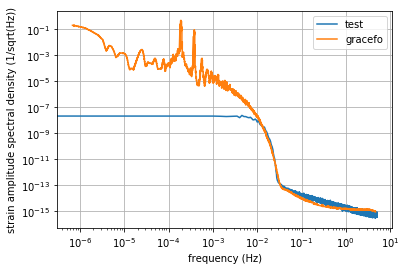

In [5]:
##Compare merged noise curves with gracefo data
plt.loglog(combined_fs.sample_frequencies, np.sqrt(combined_fs), label='test')
plt.loglog(grace_freqs, grace_strain, label='gracefo')

plt.legend()
plt.xlabel('frequency (Hz)')
plt.ylabel('strain amplitude spectral density (1/sqrt(Hz))')
plt.grid()
plt.legend()

plt.savefig('grace_fo_model_curve_comparison.png')
plt.show()

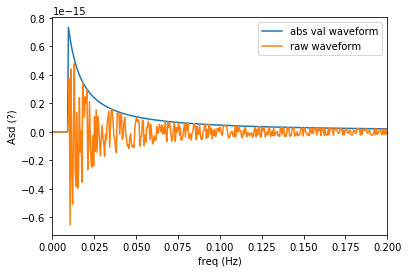

[0.00000000e+00 5.02512563e-04 1.00502513e-03 ... 2.63460302e+02
 2.63460804e+02 2.63461307e+02]
[0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
 0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
 0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
 0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
 0.00000000e+00+0.00000000e+00j 1.33875975e-16-7.21202049e-16j]


In [10]:
# 4 - Generate Frequency Domain Waveform

#apx = 'TaylorF2'
apx = 'IMRPhenomD'

m1 = 100.0
m2 = 100.0
f_low = 0.01
df = combined_fs.delta_f

hp_fd, hc_fd = get_fd_waveform(approximant = apx,
                               mass1=m1, mass2=m2,
                               f_lower=f_low,
                               delta_f=df)

plt.loglog(hp_fd.sample_frequencies, np.real(hp_fd), label='real val waveform')
plt.loglog(hp_fd.sample_frequencies, hp_fd, label='raw waveform')
plt.xlabel('freq (Hz)')
plt.ylabel('Asd (?)')
plt.legend(loc='upper right')
#plt.xlim(0, 0.2)
plt.show()

print(hp_fd.sample_frequencies)
print(hp_fd[10:20])

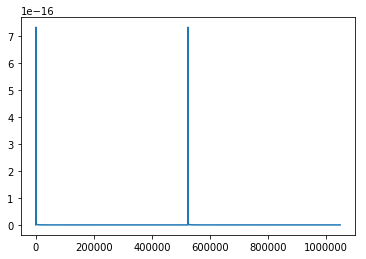

In [13]:
# 4.5 - editing fs waveform for the np.fft.ifft 
#which requires negative frequencies as well

#make unique copies of template
hp_pos_c = hp_fd.copy()
hp_neg_c = hp_fd.copy()

#reverse the negative frequencyseries array
hp_flip = np.abs(np.flip(hp_neg_c))

#combine the two asd arrays
combined_arrays = np.concatenate((np.abs(hp_pos_c), np.abs(hp_pos_c)))

#create combined sample frequecy arrays
#print(hp_neg_c.sample_frequencies)
#freqs1 = np.flip(-1.0 * hp_neg_c.sample_frequencies)
#print(freqs1)

#freqs2 = hp_pos_c.sample_frequencies.copy()
#neg_pos_freqs = np.concatenate((freqs1, freqs2))

#print(type(combined_arrays))

plt.plot(combined_arrays)
#plt.xlabel('freqs (Hz)')
#plt.xlim(-0.2, 0.2)
plt.show()

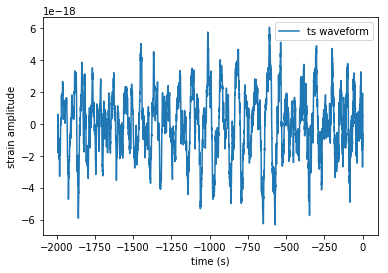

In [13]:
combined_tsc = combined_ts.copy()
hp_fd_c = hp_fd.copy()
waveform = hp_fd_c.to_timeseries()

plt.plot(waveform.sample_times, waveform, label='ts waveform')
plt.xlabel('time (s)')
plt.ylabel('strain amplitude')
plt.legend()
plt.show()

Waveform properties: size: 524289 duration: 995.0018978118895 dt: 0.0018978118896484373 df: 0.0010050232086984978


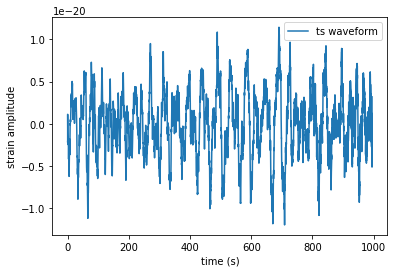

In [11]:
# 5 - Get timeseries of template via ifft

#make unique copy of noise curve
combined_tsc = combined_ts.copy()
hp_fd_c = hp_fd.copy()

#take template to timeseries
#waveform = hp_fd_c.to_timeseries() #<- appears this does not give the waveform as expected ??
waveform_array = np.fft.ifft(hp_fd_c)
#waveform_array = np.abs(np.fft.ifft(hp_fd_c))

#new trial after altering the fd waveform
#waveform_array = np.fft.ifft(combined_arrays)

waveform = types.timeseries.TimeSeries(np.real(waveform_array), delta_t=hp_fd.delta_t)
print('Waveform properties:', 'size:', np.size(waveform), 'duration:', waveform.duration, 'dt:', waveform.delta_t, 'df:', waveform.delta_f)

plt.plot(waveform.sample_times, waveform, label='ts waveform')
plt.xlabel('time (s)')
plt.ylabel('strain amplitude')
plt.legend()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (524289,) and (1,)

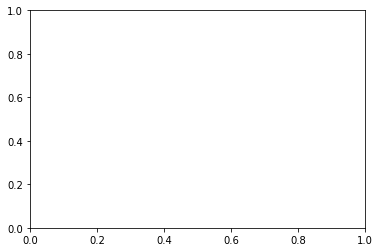

In [12]:
plt.plot(waveform.sample_times, np.real(waveform), label='ts waveform')
plt.xlabel('time (s)')
plt.ylabel('strain amplitude')
plt.legend()
plt.show()

In [12]:
hp_fd_c = hp_fd.copy()
combined_tsc = combined_ts.copy()

#take template to timeseries
waveform = np.abs(hp_fd_c).to_timeseries() 

TypeError: to_timeseries does not support real types

In [7]:
# Method 1 step 6 - Injection of template into data

#increase length of waveform to prepare for resampling
waveform.resize(10*np.size(combined_tsc))
print('Resized Waveform properties:', 'size:', np.size(waveform), 'duration:', waveform.duration, 'dt:', waveform.delta_t, 'df:', waveform.delta_f)

#Resample
resample_num = int(waveform.duration / 0.1)
waveform_resampled = sp.signal.resample(waveform, resample_num)
waveform = types.timeseries.TimeSeries(waveform_resampled, delta_t = 0.1)
print('Resampled:', 'size:', np.size(waveform), 'duration:', waveform.duration, 'dt:', waveform.delta_t, 'df:', waveform.delta_f )

waveform.resize(np.size(combined_ts))
print('Resampled and resized:', 'size:', np.size(waveform), 'duration:', waveform.duration, 'dt:', waveform.delta_t, 'df:', waveform.delta_f )


AttributeError: 'numpy.ndarray' object has no attribute 'duration'

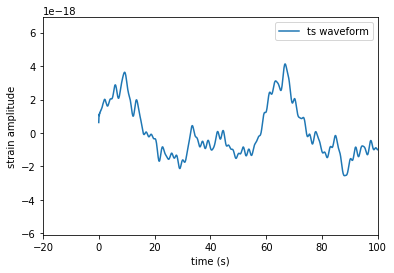

In [16]:
plt.plot(waveform.sample_times, waveform, label='ts waveform')
plt.xlabel('time (s)')
plt.ylabel('strain amplitude')
plt.xlim(-20,100)
plt.legend()
plt.show()